Preparing the Dataset and Extract Hand Landmarks

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import mediapipe as mp
import pickle
import numpy as np

2024-11-30 00:54:27.249402: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 00:54:27.261195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 00:54:27.274868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 00:54:27.278913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 00:54:27.288870: I tensorflow/core/platform/cpu_feature_guar

In [3]:


# Mediapipe Hand Landmark Detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.9)

data_dir = '/home/azureuser/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'

dataset = []
labels = []

# Loop through directories (classes)
for directory in os.listdir(data_dir):
    path = os.path.join(data_dir, directory)
    if not os.path.isdir(path):
        continue

    for img_path in os.listdir(path):
        normalized_landmarks = []
        x_coordinates, y_coordinates = [], []
        image_path = os.path.join(path, img_path)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed_image = hands.process(image_rgb)
        hand_landmarks = processed_image.multi_hand_landmarks

        if hand_landmarks:
            for hand_landmark in hand_landmarks:
                for coordinates in hand_landmark.landmark:
                    x_coordinates.append(coordinates.x)
                    y_coordinates.append(coordinates.y)

                min_x, min_y = min(x_coordinates), min(y_coordinates)
                for coordinates in hand_landmark.landmark:
                    normalized_x = coordinates.x - min_x
                    normalized_y = coordinates.y - min_y
                    normalized_landmarks.extend([normalized_x, normalized_y])

            dataset.append(normalized_landmarks)
            labels.append(directory)

# Save the dataset and labels
with open("./ASL_CNN_Data.pickle", "wb") as f:
    pickle.dump({"dataset": dataset, "labels": labels}, f)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732928079.993648    4994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732928080.014396    4994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732928080.383047    5003 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Training CNN Model

In [4]:
import os
import cv2
import mediapipe as mp
import pickle
import numpy as np

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-12-04 15:55:34.384583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 15:55:40.831062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 15:55:42.074661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 15:55:42.515067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 15:55:46.785820: I tensorflow/core/platform/cpu_feature_guar

In [5]:


# Load preprocessed dataset
with open("./ASL_CNN_Data.pickle", "rb") as f:
    data = pickle.load(f)

# Prepare data
X = np.asarray(data["dataset"])
y = np.asarray(data["labels"])

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y_one_hot, random_state=42)

# Reshape input for CNN (1D Convolution)
X_train = X_train.reshape(-1, 42, 1)  # 42 landmarks (normalized x, y) as a sequence
X_test = X_test.reshape(-1, 42, 1)

# CNN Model Architecture with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(42, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Save the model and label encoder
model.save("./ASL_CNN_Model-new.h5")
with open("./ASL_Label_Encoder.pickle", "wb") as f:
    pickle.dump(label_encoder, f)

model.summary()
print("Model trained and saved successfully!")



Epoch 1/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5239 - loss: 1.6580 - val_accuracy: 0.9742 - val_loss: 0.1241
Epoch 2/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9468 - loss: 0.2001 - val_accuracy: 0.9813 - val_loss: 0.0708
Epoch 3/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9644 - loss: 0.1319 - val_accuracy: 0.9857 - val_loss: 0.0546
Epoch 4/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9746 - loss: 0.1004 - val_accuracy: 0.9899 - val_loss: 0.0420
Epoch 5/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9780 - loss: 0.0813 - val_accuracy: 0.9914 - val_loss: 0.0356
Epoch 6/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9794 - loss: 0.0752 - val_accuracy: 0.9911 - val_loss: 0.0322
Epoch 7/20
1056/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,414 (982.09 KB)

 Trainable params: 83,804 (327.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 167,610 (654.73 KB)

Model trained and saved successfully!


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [8]:


# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions from one-hot encoding to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Convert true labels from one-hot encoding to class indices

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)


Model Accuracy: 99.69%
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[273   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0 346   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 187   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 330   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 301   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 438   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 319   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 328   0   0   0   0   0   0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

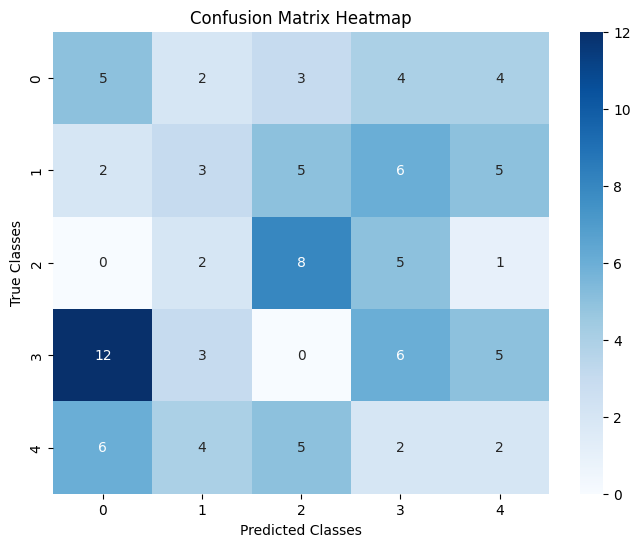

In [2]:
# Example data for demonstration purposes
np.random.seed(42)  # Remove this line if using actual data
num_classes = 5     # Replace this with the actual number of classes
y_true_classes = np.random.randint(0, num_classes, 100)  # Replace with actual true labels
y_pred_classes = np.random.randint(0, num_classes, 100)  # Replace with actual predicted labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()
